# ICAPS24 SkDecide Tutorial: Implementing a scikit-decide solver embedding the JaxPlan and GurobiPlan planners and solving RDDL-based scikit-decide domains

Alexandre Arnold, Guillaume Povéda, Florent Teichteil-Königsbuch

Credits to [IMACS](https://imacs.polytechnique.fr/) and especially to Nolwen Huet

This tutorial will demonstrate how to create a custom scikit-decide solver which can solve scikit-domains of whose characteristics are compatible with this solver.

The "characteristic" rosace of scikit-decide domains show that a solver can handle all the domains whose characteristics are *more specific* than the ones of the domain for which the solver has been designed:

<img src="images/skdecide_characteristics.png" alt="SkDecide characteristics" width="1000"/>

For instance, as depicted in this image, if the solver can handle partially observable states, then it can solve also domains whose states are fully observable.

## Environment setup (package installation)

First we install scikit-decide if it has not been already done.

In [ ]:
import os

if not os.path.exists('install_skdecide.py'):
    !wget https://raw.githubusercontent.com/fteicht/icaps24-skdecide-tutorial/main/notebooks/install_skdecide.py

from install_skdecide import install_skdecide
install_skdecide(using_nightly_version=False, force_reinstall=False)

Second, we install the RDDL benchmark set, the pyRDDLGym-jax and pyRDDLGym-gurobi solvers from the excellent [pyrddlgym-project](https://github.com/pyrddlgym-project) GitHub project.

In [ ]:
# We have dependency problems between ortools installed with scikit-decide and pRDDLGym-jax
# So we uninstall ortools which we don't need in this notebook
!pip uninstall -y ortools
!pip --default-timeout=1000 install rddlrepository pyRDDLGym-jax
!pip --default-timeout=1000 install gurobipy git+https://github.com/pyrddlgym-project/pyRDDLGym-gurobi

Third, we import the packages that will be used in this notebook.

In [13]:
from typing import Any, Callable, Optional, Dict
import os, shutil
from datetime import datetime as dt
from numpy.typing import ArrayLike


from skdecide.core import TransitionOutcome, Value, Space
from skdecide.domains import RLDomain
from skdecide.builders.domain import UnrestrictedActions, FullyObservable, Renderable
from skdecide.hub.space.gym import DictSpace, GymSpace, MultiDiscreteSpace
from skdecide.solvers import Solver
from skdecide.builders.solver import FromInitialState, Policies
from skdecide.utils import rollout

import pyRDDLGym
from pyRDDLGym.core.simulator import RDDLSimulator
from pyRDDLGym.core.env import RDDLEnv
from pyRDDLGym.core.visualizer.viz import BaseViz
from pyRDDLGym.core.visualizer.chart import ChartVisualizer
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOfflineController, JaxOnlineController
from pyRDDLGym_jax.core.simulator import JaxRDDLSimulator
from pyRDDLGym_jax.core.planner import load_config
from pyRDDLGym_gurobi.core.planner import GurobiStraightLinePlan, GurobiOnlineController
from pyRDDLGym.core.policy import RandomAgent

from rddlrepository.core.manager import RDDLRepoManager
from rddlrepository.archive.standalone.Quadcopter.QuadcopterViz import QuadcopterVisualizer
from rddlrepository.archive.standalone.Elevators.ElevatorViz import ElevatorVisualizer

import logging

from IPython.display import clear_output
%matplotlib notebook

## Code generation

Scikit-decide's [documentation website](https://airbus.github.io) offers a simple interactive interface to select the characteristics of the solver that you want to define, along with the characteristics of the domains it is intended to solve.
It also allows you to generate a template for the solver class to implement, containing the minimal set of methods that you have to implement.

You must go to the [code generator](https://airbus.github.io/scikit-decide/codegen/) page and follow the instructions in the following picture. Do not forget to click on the toggle button below the "Domain specification" frame in order to select "Create Solver".

<img src="images/skdecide_solver_generator.png" alt="SkDecide domain generator" width="1000"/>

The `pyRDDLGym-jax` and `pyRDDLGym-gurobi` solvers are compatible with the `pyRDDLGym` environment which we embedded in a scikit-decide `RDDLDomain` in the [tutorial notebook](https://github.com/fteicht/icaps24-skdecide-tutorial/blob/main/notebooks/icaps24_skdecide_tutorial_rddl_domain.ipynb) on creating custom scikit-decide domains. Those solvers actually exploit the logics model of the RDDL domain file description, `pyRDDLGym.model` of type `RDDLLiftedModel`. It means that our custom RDDL solver can embed the `pyRDDLGym-jax` and `pyRDDLGym-gurobi` planners and work on our custom `RDDLDomain` class whose characteristics rre `RLDomain`, `UnrestrictedActions`, `FullyObservable` and `Renderable`.

Our custom solver itself will produce probabilistic Markovian policies, meaning that it should inherit from `skdecide.Solver` and `skdecide.Policies`, contrary to the example screenshot above which generates the template class for a deterministic policy solver. Our custom solver will also solve a RDDL problem from the random state sampled by the `RDDLDomain.reset()` method, which corresponds to the solver characteristic `skdecide.FromInitialState`.

The code generator gives us the following solver class template which we have to fill-in:

```python

from typing import *

from skdecide import *
from skdecide.builders.domain import *
from skdecide.builders.solver import *


class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    pass


class MySolver(Solver, Policies, FromInitialState):
    T_domain = D
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        pass
    
    def _sample_action(self, observation: D.T_observation) -> D.T_event:
        pass
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        pass
```

We define in the following cell the sact same `RDDLDomain` as the one we defined in the tutorial notebook on creating custom scikit-decide domains.

In [2]:
class D(RLDomain, UnrestrictedActions, FullyObservable, Renderable):
    T_state = Dict[str, Any]  # Type of states
    T_observation = T_state  # Type of observations
    T_event = ArrayLike  # Type of events
    T_value = float  # Type of transition values (rewards or costs)
    T_info = None  # Type of additional information in environment outcome


class RDDLDomain(D):

    def __init__(self,
                 rddl_domain: str,
                 rddl_instance: str,
                 backend: RDDLSimulator = RDDLSimulator,
                 base_class: RDDLEnv = RDDLEnv,
                 visualizer: BaseViz = ChartVisualizer,
                 movie_name: str = None,
                 max_frames=100,
                 vectorized=True):
        self.rddl_gym_env = pyRDDLGym.make(rddl_domain,
                                           rddl_instance,
                                           backend=backend,
                                           base_class=base_class,
                                           enforce_action_constraints=True,
                                           vectorized=vectorized)
        self.movie_name = movie_name
        self._nb_step = 0
        if movie_name is not None:
            self.movie_path = os.path.join('rddl_movies', movie_name)
            if not os.path.exists(self.movie_path):
                os.makedirs(self.movie_path)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            if os.path.exists(tmp_pngs):
                shutil.rmtree(tmp_pngs)
            os.makedirs(tmp_pngs)
            self.movie_gen = MovieGenerator(tmp_pngs, movie_name, max_frames=max_frames)
            self.rddl_gym_env.set_visualizer(visualizer, self.movie_gen)
        else:
            self.movie_gen = None
            self.rddl_gym_env.set_visualizer(visualizer)

    def _state_step(
        self, action: D.T_event
    ) -> TransitionOutcome[D.T_state, Value[D.T_value], D.T_predicate, D.T_info]:
        next_state, reward, terminated, truncated, _ = self.rddl_gym_env.step(action)
        termination = terminated or truncated
        if self.movie_gen is not None and (termination or self._nb_step >= self.movie_gen.max_frames - 1):
            self.movie_gen.save_animation(self.movie_name)
            tmp_pngs = os.path.join(self.movie_path, 'tmp_pngs')
            shutil.move(os.path.join(tmp_pngs, self.movie_name + '.gif'),
                        os.path.join(self.movie_path, self.movie_name + '_' +
                                     str(dt.now().strftime("%Y%m%d-%H%M%S")) +
                                     '.gif'))
        self._nb_step += 1
        return TransitionOutcome(
            state=next_state, value=Value(reward=reward), termination=termination
        )

    def _get_action_space_(self) -> Space[D.T_event]:
        return GymSpace(self.rddl_gym_env.action_space)

    def _state_reset(self) -> D.T_state:
        self._nb_step = 0
        # SkDecide only needs the state, not the info
        return self.rddl_gym_env.reset()[0]

    def _get_observation_space_(self) -> Space[D.T_observation]:
        return GymSpace(self.rddl_gym_env.observation_space)

    def _render_from(self, memory: D.T_state = None, **kwargs: Any) -> Any:
        # We do not want the image to be displayed in a pygame window, but rather in this notebook
        rddl_gym_img = self.rddl_gym_env.render(to_display=False)
        clear_output(wait=True)
        display(rddl_gym_img)

## Solver implementation

The actual work begins now. It consists in implementing the contents of the methods from the generated solver class above. The implementation will depend on the actual underlying planner, which is why we will create specific implementations for each underlying RDDL solver. The methods to implement are:
- `_solve()`: solves the RDDL problem by calling a series of `rddl_domain.reset()` and `rddl_domain.step()` methods; other custom solver classes would use more or different domain methods depending on the characteristics of the domains it can handle (e.g. `domain.get_next_state_distribution()`, `domain.get_observation_distribution()`, `domain.is_goal()`, etc.)
- `_sample_action()`: samples the next action to be executed by the agent for a given state according to the solver's optimized policy distribution; for a history-dependent solver, the method would take as input a history of observations rather than just the current one;
- `is_policy_defined_for()`: indicates whether an action has been computed and is available in the given state; the RDDL planners we are using in this notebook do not explose this information in their Python API, which is why we will always return True from this method in our custom RDDL solver class.

<div class="alert alert-block alert-info"><b>Note: </b> The methods to implement are prefixed with '_' to indicate that they should be considered as protected, i.e. they should not be used by a user of the domain class like a solver. As for the domain builder classes, the solver builder classes most generally manage in background the automated casting of domain features to the solver's expected ones (e.g. single agent state to a multi-agent dictionary state if the domain is single-agent and the solver is multi-agent), appropriate re-implementation of methods when walking down the characteristic class hierarchies, and the LRU cache for those methods that can cache their results for later reuse. The user of the solver class, like the `skdecide.utils.rollout()` methods should always use the non-prefixed version of the solver methods. </div>

## Random Agent

We begin with the simple RDDL random agent which we embed in the `RDDLRandomSolver` below.
The solver instance's constructor takes as input the domain factory lambda function, as usual in the solvers provided by scikit-decide.

We show how to make additional compatibility checks on the domain beyond the domain characteristics checks, by implementing the `_check_domain_additional()` method. In this simple case, we check that the domain class provide `rddl_gym_env` attribute which is defined in the `RDDLDomain` class defined earlier in this notebook. This method will be called internally, along with other internal domain cahracteristic checking methods, by scikit-decide when the user calls `RDDLRandomSolver.check_domain(domain_instance)`.

The `_solve()` method of the rangom agent only creates a `pyRDDLGym.core.policy.RandomAgent` controller, while the `_sample_action()` method calls the `sample_action()` method of the aforementioned controller.

In [14]:
class D(RDDLDomain):
    pass

class RDDLRandomSolver(Solver, Policies, FromInitialState):
    T_domain = D

    def __init__(self, domain_factory: Callable[[], RDDLDomain]):
        Solver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')      
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        self.controller = RandomAgent(action_space = self._domain.rddl_gym_env.action_space,
                                      num_actions = self._domain.rddl_gym_env.max_allowed_actions)
    
    def _sample_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

We now load the Quadcopter RDDL problem from the `rddlrepository`.

In [9]:
manager = RDDLRepoManager(rebuild=True)
problem_info = manager.get_problem("Quadcopter")
problem_visualizer = QuadcopterVisualizer

We then create the domain factory to be used by the random agent, and render it from the initial state returned by the `domain.reset()` method.

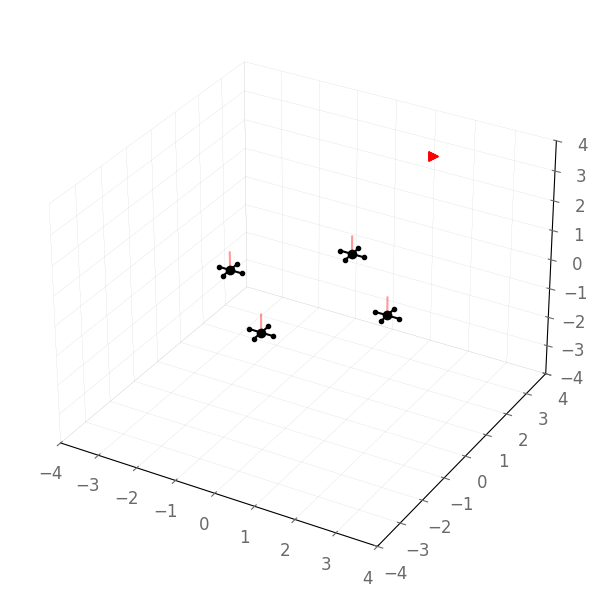

In [15]:
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger("skdecide.utils").setLevel(logging.INFO)

domain_factory_random_agent = lambda max_frames=None: RDDLDomain(
    rddl_domain=problem_info.get_domain(),
    rddl_instance=problem_info.get_instance(1),
    visualizer = problem_visualizer,
    movie_name='Quadcopter-RandomAgent' if max_frames is not None else None,
    max_frames=max_frames if max_frames is not None else 100
)
domain = domain_factory_random_agent()
domain.reset()
domain.render()

Let's now try to execute the random policy governed by the `RDDLRandomSolver`.

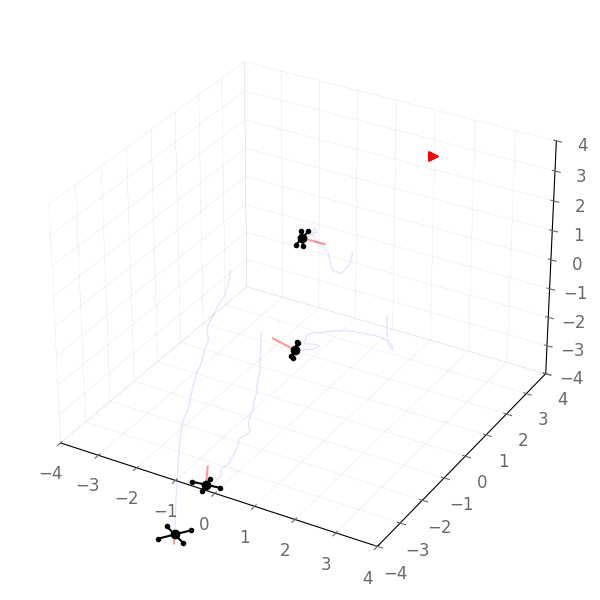

In [16]:
assert RDDLRandomSolver.check_domain(domain_factory_random_agent())

with RDDLRandomSolver(domain_factory=domain_factory_random_agent) as solver:
    solver.solve()
    rollout(
        domain_factory_random_agent(max_frames=100),
        solver,
        max_steps=100,
        render=True,
        max_framerate=5,
        verbose=False,
    )

Here is an example of the resulting solution, which obviously does not reach the goal:

![RandomAgent example solution](images/Quadcopter-RandomAgent_example.gif)

## JAX Agent

We now try the offline version of [JaxPlan](https://openreview.net/forum?id=7IKtmUpLEH) planner which compiles the RDDL model to a Jax computation graph allowing for planning by backpropagation. Don't miss the presentation of the paper this year at ICAPS!

Now, the scikit-decide `_solve()` method creates the `JaxBackpropPlanner` and the `JaxOfflineController`. The latter is used in `_sample_action()` to sample the next action to execute. The solver instance's constructor also takes the configuration file of the `Jax` planner as explained [here](https://github.com/pyrddlgym-project/pyRDDLGym-jax/tree/main?tab=readme-ov-file#writing-a-configuration-file-for-a-custom-domain).

In [17]:
class D(RDDLDomain):
    pass

class RDDLJaxSolver(Solver, Policies, FromInitialState):
    T_domain = D

    def __init__(self,
                 domain_factory: Callable[[], RDDLDomain],
                 config: Optional[str] = None):
        Solver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()
        if config is not None:
            self.planner_args, _, self.train_args = load_config(config)

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')          
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        planner = JaxBackpropPlanner(rddl=self._domain.rddl_gym_env.model,
                                     **(self.planner_args if self.planner_args is not None else {}))
        self.controller = JaxOfflineController(planner,
                                               **(self.train_args if self.train_args is not None else {}))
    
    def _sample_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

Now, we optimize the problem with `JaxPlan` and execute the resulting policy.

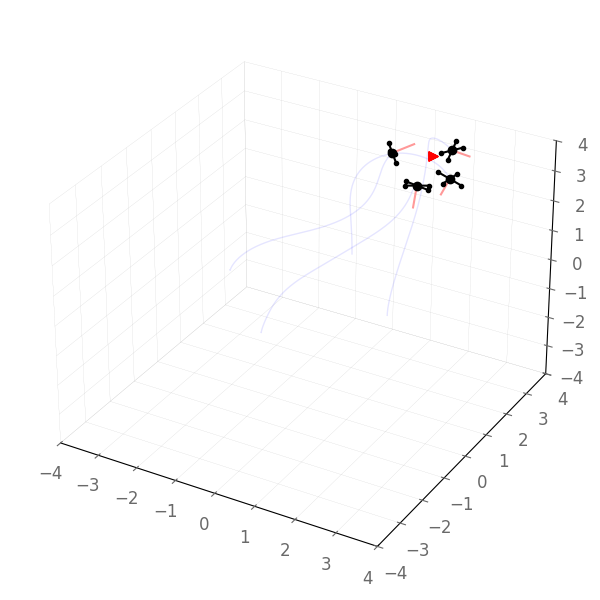

In [18]:
if not os.path.exists('Quadcopter_slp.cfg'):
    !wget https://raw.githubusercontent.com/pyrddlgym-project/pyRDDLGym-jax/main/pyRDDLGym_jax/examples/configs/Quadcopter_slp.cfg

domain_factory_jax_agent = lambda max_frames=None: RDDLDomain(
    rddl_domain=problem_info.get_domain(),
    rddl_instance=problem_info.get_instance(1),
    visualizer = problem_visualizer,
    backend=JaxRDDLSimulator,
    movie_name='Quadcopter-JaxAgent' if max_frames is not None else None,
    max_frames=max_frames if max_frames is not None else 500
)

assert RDDLJaxSolver.check_domain(domain_factory_jax_agent())

with RDDLJaxSolver(domain_factory=domain_factory_jax_agent,
                   config='Quadcopter_slp.cfg') as solver:
    solver.solve()
    rollout(
        domain_factory_jax_agent(max_frames=500),
        solver,
        max_steps=500,
        render=True,
        max_framerate=5,
        verbose=False,
    )

We obtain the following example execution of the `Jax` policy, which now clearly converges towards the goal (quadcopters flying towards the red triangle):

![JaxAgent example solution](images/Quadcopter-JaxAgent_example.gif)

## Gurobi Agent

We finally try the online version of [GurobiPlan](https://openreview.net/forum?id=7IKtmUpLEH) planner which compiles the RDDL model to a Gurobi MILP model. Don't miss the presentation of the paper this year at ICAPS!

Now, the scikit-decide `_solve()` method creates the `GurobiStraightLinePlan` and the `GurobiOnlineController`. The latter is used in `_sample_action()` to sample the next action to execute.

In [3]:
class D(RDDLDomain):
    pass

class RDDLGurobiSolver(Solver, Policies, FromInitialState):
    T_domain = D

    def __init__(self,
                 domain_factory: Callable[[], RDDLDomain],
                 config: Optional[str] = None,
                 rollout_horizon=5):
        Solver.__init__(self, domain_factory=domain_factory)
        self._domain = domain_factory()
        self._rollout_horizon = rollout_horizon
        if config is not None:
            self.planner_args, _, self.train_args = load_config(config)

    @classmethod
    def _check_domain_additional(cls, domain: D) -> bool:
        return hasattr(domain, 'rddl_gym_env')          
    
    def _solve(self, from_memory: Optional[D.T_state] = None) -> None:
        plan = GurobiStraightLinePlan()
        self.controller = GurobiOnlineController(rddl=self._domain.rddl_gym_env.model,
                                                 plan=plan,
                                                 rollout_horizon=self._rollout_horizon,
                                                 model_params={'NonConvex': 2, 'OutputFlag': 0})
    
    def _sample_action(self, observation: D.T_observation) -> D.T_event:
        return self.controller.sample_action(observation)
    
    def _is_policy_defined_for(self, observation: D.T_observation) -> bool:
        return True

We try this solver on one of the well-known `Elevators` benchmarks, using a rollout horizon of 10 (larger horizon values will significantly increase the MILP model size and solving time).

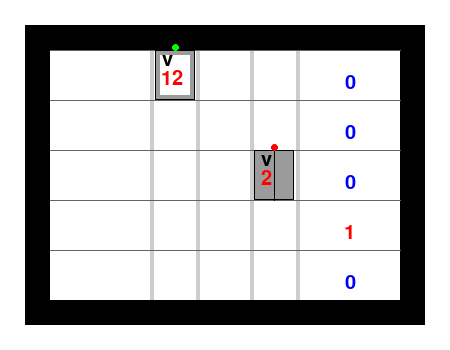

In [6]:
problem_info = manager.get_problem("Elevators")
problem_visualizer = ElevatorVisualizer

domain_factory_gurobi_agent = lambda max_frames=None: RDDLDomain(
    rddl_domain=problem_info.get_domain(),
    rddl_instance=problem_info.get_instance(0),
    visualizer = problem_visualizer,
    movie_name='Elevators-GurobiAgent' if max_frames is not None else None,
    max_frames=max_frames if max_frames is not None else 500,
    vectorized=False
)

assert RDDLGurobiSolver.check_domain(domain_factory_gurobi_agent())

with RDDLGurobiSolver(domain_factory=domain_factory_gurobi_agent, rollout_horizon=10) as solver:
    solver.solve()
    rollout(
        domain_factory_gurobi_agent(max_frames=50),
        solver,
        max_steps=50,
        render=True,
        max_framerate=5,
        verbose=False,
    )

Here is an example of executing the online `GurobiPlan` strategy on this benchmark:

![GurobiAgent example solution](images/Elevators-GurobiAgent_example.gif)